# Interactive Parallel Computing with IPython Parallel.

In [1]:
 pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipyparallel

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import ipyparallel as ipp

Cluster- Start and Connect

In [2]:
rc = ipp.Cluster(n=4).start_and_connect_sync()

Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


/Users/ira/Library/Python/3.10/lib/python/site-packages/ipyparallel/util.py:212: RuntimeWarning: IPython could not determine IPs for Iras-MacBook-Air.local: [Errno 8] nodename nor servname provided, or not known
  warnings.warn(


100%|██████████| 4/4 [00:01<00:00,  2.26engine/s]


In [5]:
rc.ids

[0, 1, 2, 3]

Views

In [9]:
v01=rc[0:2] # First two engines(0 and 1)
v23=rc[2:4] # Engines 2 and 3
view=rc[:] # All available engines

Parallel Magic

In [10]:
%px import numpy as np # Import on all engines
import numpy as np # do it locally, too

In [11]:
%%px --local
np.__version__

'1.26.4'

Out[0:2]: '1.26.4'

Out[1:2]: '1.26.4'

Out[2:2]: '1.26.4'

Out[3:2]: '1.26.4'

# Numba Vectorize

A Simple Trig Function

In [19]:
import math
import numpy as np

In [20]:
def sinacosb(a, b):
    "Calculate the product of sin(a) and cos(b)"
    return math.sin(a)*math.cos(b)

Passing numpy arrays as arguuments

In [21]:
n=1000000
a=np.ones(n, dtype='int8')
b=2*a

In [22]:
sinacosb(a,b) # only length-1 arrays can be converted to Python scalars

TypeError: only length-1 arrays can be converted to Python scalars

In [23]:
# Numpy.vectorize
npsinacosb= np.vectorize(sinacosb)

In [24]:
%timeit npsinacosb(a,b)

215 ms ± 7.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 27.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [37]:
#Numba.vectorize
from numba import vectorize
usinacosb=vectorize(sinacosb)

In [38]:
%timeit usinacosb(a,b)


11.1 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
# Eager Compilation
usinacosb= vectorize(['f8(i8,i8)', 'f4(i4,i4)', 'f8(f8,f8)'], nopython=True)(sinacosb) # 8 bytes int, 4 bytes float, 8 bytes float

In [45]:
# Target
pusinacosb=vectorize(['f8(i8,i8)', 'f4(i4,i4)', 'f8(f8,f8)'], target='parallel', nopython=True)(sinacosb)           

In [41]:
%timeit pusinacosb(a,b)

15.8 ms ± 688 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
n=100000000
a=np.ones(n, dtype='int8')
b=2*a

In [47]:
%timeit usinacosb(a,b)
%timeit pusinacosb(a,b) 
# The parallel version is slower than the serial version because the overhead of parallelization is too high for small arrays

1.5 s ± 9.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.53 s ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Excercise: The Mandelbrot Set


$z_{i+1}=z_{i}^{2} + c$

In [48]:
# Escape Time Algorithm
def escape_time(p, maxtime):
    z=0j
    for i in range(maxtime):
        z=z**2+p
        if abs(z)>2:
            return i
    return maxtime

TODO:

1. Generate a grid size of n times m of complex numbers with the real part taken from the interval [-2.2,1.5] and the imaginary part taken from the interval [-1.5,1.5]. Hint, numpy.meshgrid can help
2. Vectorize escape_time using numba.vectorize and apply it to the array above. Note, the output is an integer.
3. Visualize the generated array using matplotlib.pyplot.imshow

In [70]:
def generate_grid(n, m):
    real = np.linspace(-2.2, 1.5, n)
    imag = np.linspace(-1.5, 1.5, m)
    real_grid, imag_grid = np.meshgrid(real, imag)
    complex_grid = real_grid + 1j * imag_grid
    return complex_grid

In [71]:
@vectorize(['int32(complex128, int32)'], target='parallel')# p is complex128, maxtime is int32 and the return is int32
def escape_time(p, maxtime):
    z = 0j
    for time in range(maxtime):
        z = z**2 + p
        if abs(z) > 2:
            return time
    return maxtime

In [72]:
import matplotlib.pyplot as plt
def visualize_mandelbrot(n, m, maxtime):
    complex_grid = generate_grid(n, m)
    escape_times = escape_time(complex_grid, maxtime)
    plt.imshow(escape_times, extent=(-2.2, 1.5, -1.5, 1.5))
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.show()

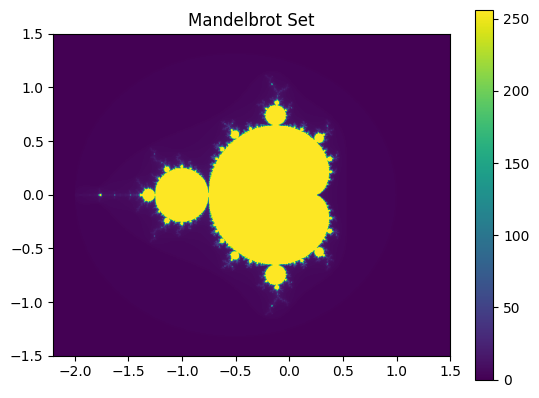

In [73]:
n = 800  # Width of the grid
m = 600  # Height of the grid
maxtime = 256  # Maximum number of iterations

# Visualize the Mandelbrot set
visualize_mandelbrot(n, m, maxtime)

# Introduction to Dask

In [4]:
import random
from time import sleep
from dask import delayed

In [5]:
def input_task(myinput):
  sleep(0.5)
  #sleep(random.random()/2)
input_task=delayed(input_task)

def common_task():
  #sleep(random.random()/2 +2.5)
  sleep(3)
common_task=delayed(common_task)

def mapitem_task(item,common):
  #sleep(random.random()* 4)
  sleep(2)
mapitem_task=delayed(mapitem_task)

def summarize_Task(intermediates):
  #sleep(random.random()* 2)
  sleep(1)
summarize_Task=delayed(summarize_Task)

In [7]:
pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


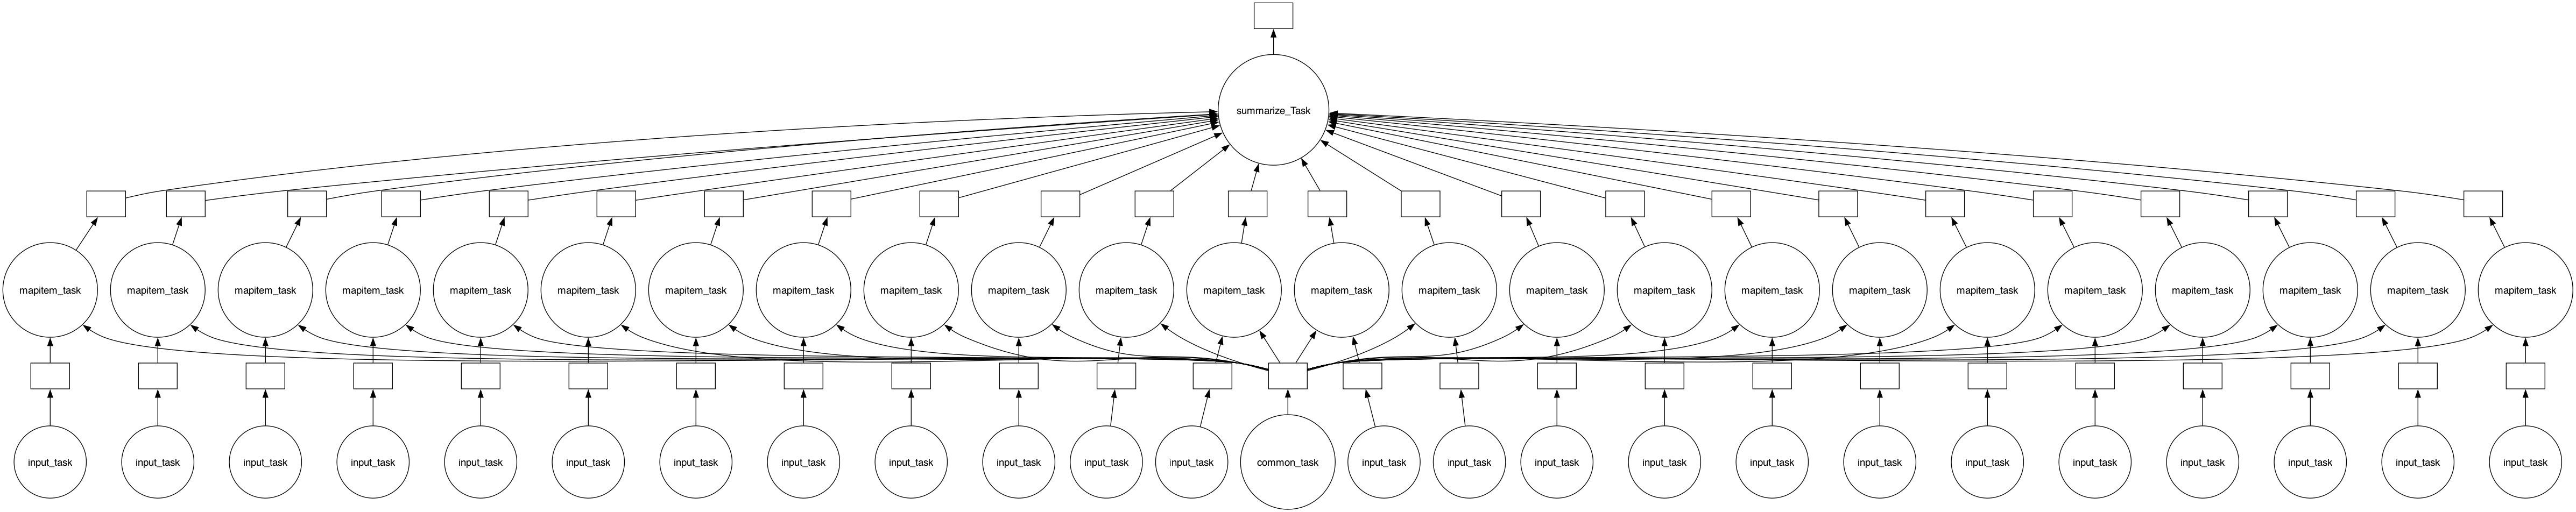

In [9]:
##taskgraph
import graphviz
prepared=[input_task(i) for i in range(24)]
common_data=common_task()
intermediates=[mapitem_task(item,common_data) for item in prepared]
result=summarize_Task(intermediates)
result.visualize()

In [10]:
%time result.compute()

CPU times: user 1.6 s, sys: 899 ms, total: 2.5 s
Wall time: 10.8 s


DASK.BAG

In [11]:
from operator import add
import dask.bag as db

In [12]:
l=[x for x in range(1000000)]
s=db.from_sequence(l, npartitions=4) # manually set the number of partitions
mysum=s.fold(add) # fold performs a parallel reduction

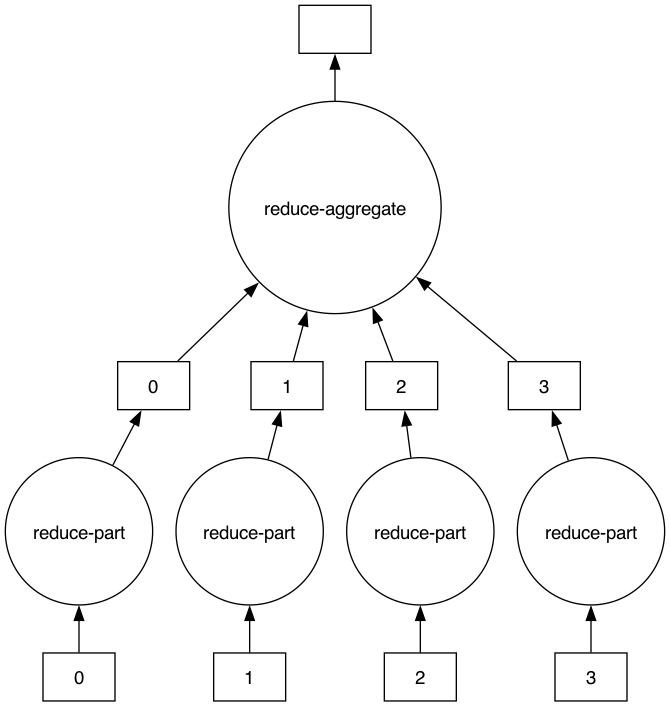

In [13]:
mysum.visualize()

DASK.ARRAY

In [14]:
import dask.array as da
x= da.ones((5,15), chunks=(5,5))
x.dask

HighLevelGraph with 1 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x14925cc50>
 0. ones_like-358bd7b7c1b2ac8759520ddaf95cfe13

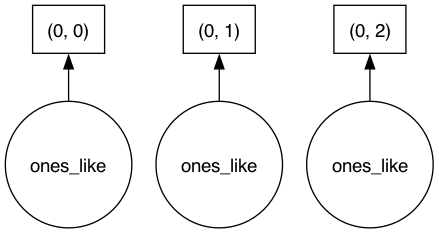

In [15]:
x.visualize()

DASK.DISTRIBUTED

In [3]:
pip install dask distributed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from dask.distributed import Client
from dask.distributed import LocalCluster
lc=LocalCluster(n_workers=24, threads_per_worker=2)

In [2]:
c=Client(lc)
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 48,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54628,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:54687,Total threads: 2
Dashboard: http://127.0.0.1:54693/status,Memory: 341.33 MiB
Nanny: tcp://127.0.0.1:54631,


In [3]:
A=c.map(lambda x: x**2, range(100))

In [4]:
result_list=c.gather(A)
result_list[:15]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196]

In [5]:
c.close()

In [6]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 48,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54628,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: 4 minutes ago,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:54687,Total threads: 2
Dashboard: http://127.0.0.1:54693/status,Memory: 341.33 MiB
Nanny: tcp://127.0.0.1:54631,


# Introduction to MPI

Setting up for MPI and running a MPI program from your MacOS Terminal

In [ ]:
# make a python file having the following program: mpi_setup_example.py and save in Downloads folder
""" 
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

print("I'm %d of %d. Resistance is futile." %(rank+1, size))

"""

# Open your Terminal and run the following commands
""" 
>cd Downloads
>export PYTHONPATH=$PYTHONPATH:/path/to/your/directory
>mpiexec -n 4 python -m mpi_setup_example

"""

# Output
"""
I'm 3 of 4. Resistance is futile.
I'm 1 of 4. Resistance is futile.
I'm 2 of 4. Resistance is futile.
I'm 4 of 4. Resistance is futile. 

"""


Point to Point

In [ ]:
# make a python file having the following program: mpi_point_to_point.py and save in Downloads folder
""" 
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Generate random numbers in each process
np.random.seed(rank)
a = np.random.random(10)

# Compute local sum
local_sum = np.sum(a)

# Gather all local sums at rank 0
total_sum = comm.reduce(local_sum, op=MPI.SUM, root=0)

# Rank 0 process prints the total and average
if rank == 0:
    num_elements = size * len(a)  # Total number of elements
    average = total_sum / num_elements
    print("The sum of the random numbers is %f. The average is %f." % (total_sum, average))

Explanation
Generate Random Numbers: Each process generates its own random numbers.
Compute Local Sum: Each process computes the sum of its numbers.
Gather Sums: The comm.reduce function gathers the sums from all processes and computes the total sum on rank 0.
Print Results: Rank 0 computes the average and prints the results.

"""

# Open your Terminal and run the following commands
""" 
>cd Downloads
>export PYTHONPATH=$PYTHONPATH:/path/to/your/directory
>mpiexec -n 4 python -m mpi_point_to_point

"""

# Output
"""
The sum of the random numbers is 17.566989. The average is 0.439175.

"""

Upper vs Lowercase in MPI4PY: 

In MPI (Message Passing Interface) with mpi4py, communication is generally case-sensitive, meaning that function names and constants are case-sensitive

In [ ]:
# make a python file having the following program: mpi_case_sensitive.py and save in Downloads folder
""" 
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    if rank == 0:
        print("I am the root process.")

    # Case-sensitive usage of MPI functions and constants
    if rank == 0:
        # Sending a message to all other processes
        for i in range(1, size):
            comm.send("Hello from root!", dest=i, tag=11)

    else:
        # Receiving a message from root process
        message = comm.recv(source=0, tag=11)
        print(f"Process {rank} received message: {message}")

if __name__ == "__main__":
    main()

"""

# Open your Terminal and run the following commands
""" 
>cd Downloads
>export PYTHONPATH=$PYTHONPATH:/path/to/your/directory
>mpiexec -n 4 python -m mpi_case_sensitive

"""

# Output
"""
I am the root process.
Process 2 received message: Hello from root!
Process 3 received message: Hello from root!
Process 1 received message: Hello from root!

"""

Amdahl's Law

$$ t_1= t_s + t_p$$
$$t_n= t_s + t_p/n $$
$$s_n= \frac{t_1}{t_n}$$
$$s_n= \frac{t_s+t_p}{t_s+ t_p/n}$$
$$s_n=\frac{1}{(1-f)+f/n} $$

In [29]:
def amdahl_speedup(f, n):
    """
    Calculate the speedup according to Amdahl's Law.

    Parameters:
    f (float): The fraction of the program that can be parallelized (0 <= f <= 1).
    n (int): The number of processors.

    Returns:
    float: The theoretical speedup.
    """
    if f < 0 or f > 1:
        raise ValueError("Fraction f must be between 0 and 1.")
    if n <=0:
        raise ValueError("Number of processors n must be greater than 0.")
    
    return 1 / ((1 - f) + (f / n))

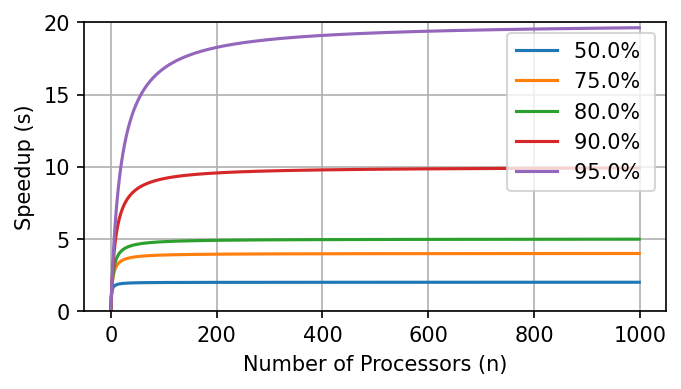

In [34]:
import matplotlib.pyplot as plt
# Number of processors
processor_counts = np.arange(0.01, 1000)

# Plot settings
plt.figure(figsize=(5, 2.5), dpi=150)

# Plot speedup for different fractions of parallelizable code
for f in [0.5, 0.75, 0.8, 0.9, 0.95]:
    speedups = [amdahl_speedup(f, n) for n in processor_counts]
    plt.plot(processor_counts, speedups, label=f"{f*100}% ")

# Plot customization
plt.legend()
plt.ylim([0, 20])
plt.xlabel('Number of Processors (n)')
plt.ylabel('Speedup (s)')

# Show plot
plt.grid(True)
plt.show()

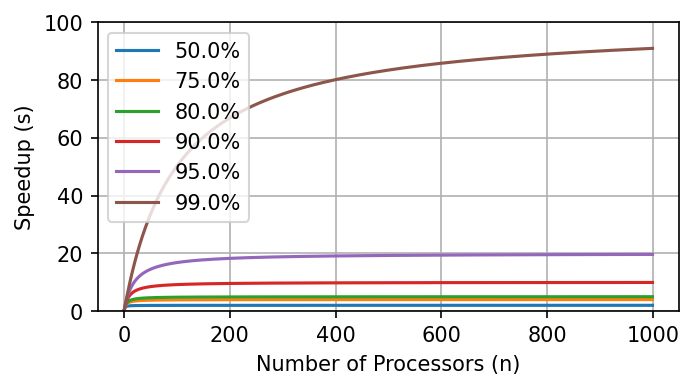

In [35]:
# Number of processors
processor_counts = np.arange(0.01, 1000)

# Plot settings
plt.figure(figsize=(5, 2.5), dpi=150)

# Plot speedup for different fractions of parallelizable code
for f in [0.5, 0.75, 0.8, 0.9, 0.95, 0.99]:
    speedups = [amdahl_speedup(f, n) for n in processor_counts]
    plt.plot(processor_counts, speedups, label=f"{f*100}%")

# Plot customization
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Number of Processors (n)')
plt.ylabel('Speedup (s)')

# Show plot
plt.grid(True)
plt.show()